### Import Packages

In [43]:
import os
import glob

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.datasets.samples_generator import make_blobs
from sklearn import preprocessing


from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC, OneClassSVM
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, MeanShift

import eli5
from eli5.sklearn import PermutationImportance

from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl
import seaborn as sns

from IPython.display import display, HTML

display(HTML(data="""<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
</style>"""))

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Importing and Loading Data

In [7]:
# Create a folder e.g. DMC_2019_task and store the original CSV-files train.csv and test.csv there or
# just modify the path variable, That's up to you!

path = "C:/Users/Vahid/Desktop/DMC_2019_task/"

for path_fileName in glob.glob(path + '*.csv'):
    if 'train' in path_fileName:
        DF_Train = pd.read_csv(path_fileName, sep='|')
    elif 'test' in path_fileName:
        DF_Test = pd.read_csv(path_fileName, sep='|')
    else:
        print('No valid CSV-Files in this folder: {}'.format(path))

pd.DataFrame({'Data Set': ['Training Set', 'Test Set'],
              'Number of Rows': [DF_Train.shape[0], DF_Test.shape[0]],
              'Number of Columns': [DF_Train.shape[1], DF_Test.shape[1]]})

,Data Set,Number of Rows,Number of Columns
0,Training Set,1879,10
1,Test Set,498121,9


### Data Set & Features

| COLUMN NAME | DESCRIPTION | VALUE RANGE |
| ----------- | :-----------: | :------------: |
| <b>trustLevel</b>  | A customer’s individual trust level. 6: Highest trustworthiness | {1,2,3,4,5,6} |
| <b>totalScanTimeInSeconds</b> | Total time in seconds between the first and last product scanned | {1,2,3,4,5,6} |
| <b>grandTotal</b> | Grand total of products scanned | Positive decimal number with maximum two decimal places |
| <b>lineItemVoids</b> | Number of voided scans | Positive whole number |
| <b>scansWithoutRegistration</b> | Number of attempts to activate the scanner without actually scanning anything | Positive whole number or 0 |
| <b>quantityModification</b> | Number of attempts to activate the scanner without actually scanning anything | Positive whole number or 0 |
| <b>scannedLineItemsPerSecond | Average number of scanned products per second | Positive decimal number |
| <b>valuePerSecond</b> | Average total value of scanned products per second | Positive decimal number |
| <b>lineItemVoidsPerPosition</b> | Average number of item voids per total number of all scanned and not cancelled products | Positive decimal number |
| <b>fraud</b> | Classification as fraud (1) or not fraud (0) | {0,1} |

### Data Preprocessing
* Shuffling the Data Frame (Training Set)
* Creating Feature Set (X) and Labels (y) for Training Set
* Creating Feature Set for Test Set
* Converting the data type of features to float

In [8]:
random_state = 0

DF_Train = DF_Train.sample(frac=1, random_state=random_state).astype(float)#.reset_index(drop=True)

X = DF_Train.values[:, 0:9].astype(float)
y = DF_Train.values[:, 9].astype(float)

X_test = DF_Test.values[:, 0:9].astype(float)

n_samples_Tr = X.shape[0]
n_features_Tr = X.shape[1]
n_classes_Tr = len(np.unique(y))

print("Total Training Set Size:")
print("n_samples: %d" % n_samples_Tr)
print("n_features: %d" % n_features_Tr)
print("n_classes: %d" % n_classes_Tr)

n_samples_Te = X_test.shape[0]
n_features_Te = X_test.shape[1]

print("\nTotal Test Set Size:")
print("n_samples: %d" % n_samples_Te)
print("n_features: %d" % n_features_Te)

Total Training Set Size:
n_samples: 1879
n_features: 9
n_classes: 2

Total Test Set Size:
n_samples: 498121
n_features: 9


### Feature Selection
<b>
1. Detecting missing values and duplication
2. Amount of variation
3. Pairwise correlation
4. Multicolinearity
5. Principal Component Analysis (PCA)
6. Cluster analysis
7. Correlation (with the target)
8. Forward selection
9. Backward elimination
10. Stepwise selection
11. LASSO
12. Tree-based selection
</b>

## 1. Detecting missing values and duplication (Data Cleaning)

* Detect Missing Data/ Values for Training Set and Test Set
* Detect Duplication in Training Set and Test Set
* Drop variables that have a very high % of missing values
* Review or visualize variables with high % of missing values

In [9]:
# Missing values
print(DF_Train.isnull().values.any())
print(DF_Test.isnull().values.any())

# Duplication
print(DF_Train.duplicated().values.any())
print(DF_Test.duplicated().values.any())

False
False
False
False


## 2. Amount of variation

* Detecting Missing Data/ Values for Training Set and Test Set
* Detecting Duplication in Training Set and Test Set
* Drop or review variables that have a very low variation
    * $𝑽𝑨𝑹(𝒙) = 𝝈^2 = \frac{1}{n} \sum_{i=1}^n (x_i-𝝁)^2$
    * Either standardize all variables, or use standard deviation 𝝈 to account for variables with different scales
    * Drop variables with zero variation (unary)

In [16]:
DF_Train.describe().T

,count,mean,std,min,25%,50%,75%,max
trustLevel,1879.0,3.401809,1.709404,1.000000,2.000000,3.000000,5.000000,6.000000
totalScanTimeInSeconds,1879.0,932.153273,530.144640,2.000000,474.500000,932.000000,1397.000000,1831.000000
grandTotal,1879.0,50.864492,28.940202,0.010000,25.965000,51.210000,77.285000,99.960000
lineItemVoids,1879.0,5.469931,3.451169,0.000000,2.000000,5.000000,8.000000,11.000000
scansWithoutRegistration,1879.0,4.904204,3.139697,0.000000,2.000000,5.000000,8.000000,10.000000
quantityModifications,1879.0,2.525279,1.695472,0.000000,1.000000,3.000000,4.000000,5.000000
scannedLineItemsPerSecond,1879.0,0.058138,0.278512,0.000548,0.008384,0.016317,0.032594,6.666667
valuePerSecond,1879.0,0.201746,1.242135,0.000007,0.027787,0.054498,0.107313,37.870000
lineItemVoidsPerPosition,1879.0,0.745404,1.327241,0.000000,0.160000,0.350000,0.666667,11.000000
fraud,1879.0,0.055349,0.228720,0.000000,0.000000,0.000000,0.000000,1.000000


In [17]:
DF_Train[DF_Train.fraud == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
trustLevel,104.0,1.144231,0.353025,1.000000,1.000000,1.000000,1.000000,2.000000
totalScanTimeInSeconds,104.0,1173.913462,471.260881,91.000000,819.000000,1309.500000,1540.500000,1830.000000
grandTotal,104.0,51.034327,30.298933,0.260000,27.072500,48.670000,76.862500,99.820000
lineItemVoids,104.0,6.375000,3.498092,0.000000,3.000000,6.000000,10.000000,11.000000
scansWithoutRegistration,104.0,5.865385,3.211199,0.000000,3.000000,7.000000,8.250000,10.000000
quantityModifications,104.0,2.519231,1.654536,0.000000,1.000000,2.000000,4.000000,5.000000
scannedLineItemsPerSecond,104.0,0.031582,0.034298,0.011692,0.016411,0.020436,0.033966,0.307692
valuePerSecond,104.0,0.053622,0.045918,0.000661,0.026209,0.043697,0.071838,0.230802
lineItemVoidsPerPosition,104.0,0.251412,0.146440,0.000000,0.130435,0.245000,0.379721,0.578947
fraud,104.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
DF_Train[DF_Train.fraud == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
trustLevel,1775.0,3.534085,1.664282,1.000000,2.000000,3.000000,5.000000,6.000000
totalScanTimeInSeconds,1775.0,917.988169,530.102033,2.000000,466.500000,916.000000,1374.000000,1831.000000
grandTotal,1775.0,50.854541,28.867495,0.010000,25.865000,51.260000,77.350000,99.960000
lineItemVoids,1775.0,5.416901,3.442022,0.000000,2.000000,5.000000,8.000000,11.000000
scansWithoutRegistration,1775.0,4.847887,3.127228,0.000000,2.000000,5.000000,7.000000,10.000000
quantityModifications,1775.0,2.525634,1.698295,0.000000,1.000000,3.000000,4.000000,5.000000
scannedLineItemsPerSecond,1775.0,0.059693,0.286364,0.000548,0.007916,0.015873,0.032378,6.666667
valuePerSecond,1775.0,0.210424,1.277445,0.000007,0.028089,0.055407,0.111690,37.870000
lineItemVoidsPerPosition,1775.0,0.774348,1.359578,0.000000,0.163333,0.363636,0.714286,11.000000
fraud,1775.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
DF_Test.describe().T

,count,mean,std,min,25%,50%,75%,max
trustLevel,498121.0,3.503257,1.707662,1.000000,2.000000,4.000000,5.000000,6.00
totalScanTimeInSeconds,498121.0,915.608772,528.772880,1.000000,458.000000,916.000000,1374.000000,1831.00
grandTotal,498121.0,49.988990,28.873426,0.000000,24.930000,50.030000,75.020000,99.99
lineItemVoids,498121.0,5.495926,3.447683,0.000000,3.000000,5.000000,8.000000,11.00
scansWithoutRegistration,498121.0,5.001281,3.163795,0.000000,2.000000,5.000000,8.000000,10.00
quantityModifications,498121.0,2.499015,1.708182,0.000000,1.000000,2.000000,4.000000,5.00
scannedLineItemsPerSecond,498121.0,0.068054,0.521092,0.000546,0.008682,0.016940,0.033929,30.00
valuePerSecond,498121.0,0.222182,1.717867,0.000000,0.027348,0.054550,0.109091,99.71
lineItemVoidsPerPosition,498121.0,0.735190,1.320235,0.000000,0.160000,0.352941,0.692308,11.00


## 3. Pairwise correlation

* Many variables are often correlated with each other, and hence redundant.
* If two variables are highly correlated, keeping only one will help reduce dimensionality without If two variables are highly correlated, keeping only one will help reduce dimensionality without much loss of information
* Which variable to keep? <b>The one that has a higher correlation coefficient with the target.</b>

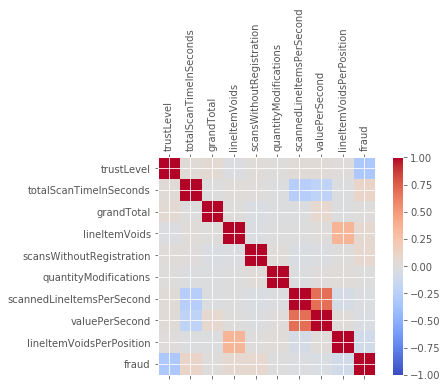

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
trustLevel,1.000000,0.025264,0.047656,-0.017312,0.017296,0.006506,0.030701,0.027626,0.009241,-0.319765
totalScanTimeInSeconds,0.025264,1.000000,-0.001230,0.019068,0.009066,-0.011415,-0.262988,-0.208450,-0.011623,0.110414
grandTotal,0.047656,-0.001230,1.000000,0.006321,-0.030573,-0.008163,-0.011885,0.075679,-0.008858,0.001421
lineItemVoids,-0.017312,0.019068,0.006321,1.000000,-0.017023,-0.007173,-0.004438,0.005114,0.346514,0.063496
scansWithoutRegistration,0.017296,0.009066,-0.030573,-0.017023,1.000000,0.018961,-0.024126,-0.018844,0.002834,0.074123
quantityModifications,0.006506,-0.011415,-0.008163,-0.007173,0.018961,1.000000,-0.014880,0.010548,0.018318,-0.000864
scannedLineItemsPerSecond,0.030701,-0.262988,-0.011885,-0.004438,-0.024126,-0.014880,1.000000,0.692152,-0.056316,-0.023085
valuePerSecond,0.027626,-0.208450,0.075679,0.005114,-0.018844,0.010548,0.692152,1.000000,0.019886,-0.028873
lineItemVoidsPerPosition,0.009241,-0.011623,-0.008858,0.346514,0.002834,0.018318,-0.056316,0.019886,1.000000,-0.090116
fraud,-0.319765,0.110414,0.001421,0.063496,0.074123,-0.000864,-0.023085,-0.028873,-0.090116,1.000000


In [20]:
# Identify pairs of highly correlated variables (pearson : standard correlation coefficient)
corr_matrix = DF_Train.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr_matrix,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(DF_Train.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(DF_Train.columns)
ax.set_yticklabels(DF_Train.columns)
plt.show()

# Correlation Table
corr_matrix

In [21]:
# Abs. Correlation coefficient tolerance
coefficient_tolerance = 0.3
# # Identify pairs of highly correlated variables: Select Valriables (pairs) with correlation >= 0.3 or <= -0.3
high_correlated_variables = [i for i in corr_matrix[np.logical_or((corr_matrix >= coefficient_tolerance), (corr_matrix <= -coefficient_tolerance))].stack().index.tolist() if i[0] != i[1]]
high_correlated_variables_values = [corr_matrix.at[i[0], i[1]] for i in high_correlated_variables]
pd.DataFrame(data = {"Variables": [(i[0], i[1]) for i in high_correlated_variables][:int(len(high_correlated_variables)/2)] ,
                     "correlation": high_correlated_variables_values[:int(len(high_correlated_variables_values)/2)]})

,Variables,correlation
0,"(trustLevel, fraud)",-0.319765
1,"(lineItemVoids, lineItemVoidsPerPosition)",0.346514
2,"(scannedLineItemsPerSecond, valuePerSecond)",0.692152


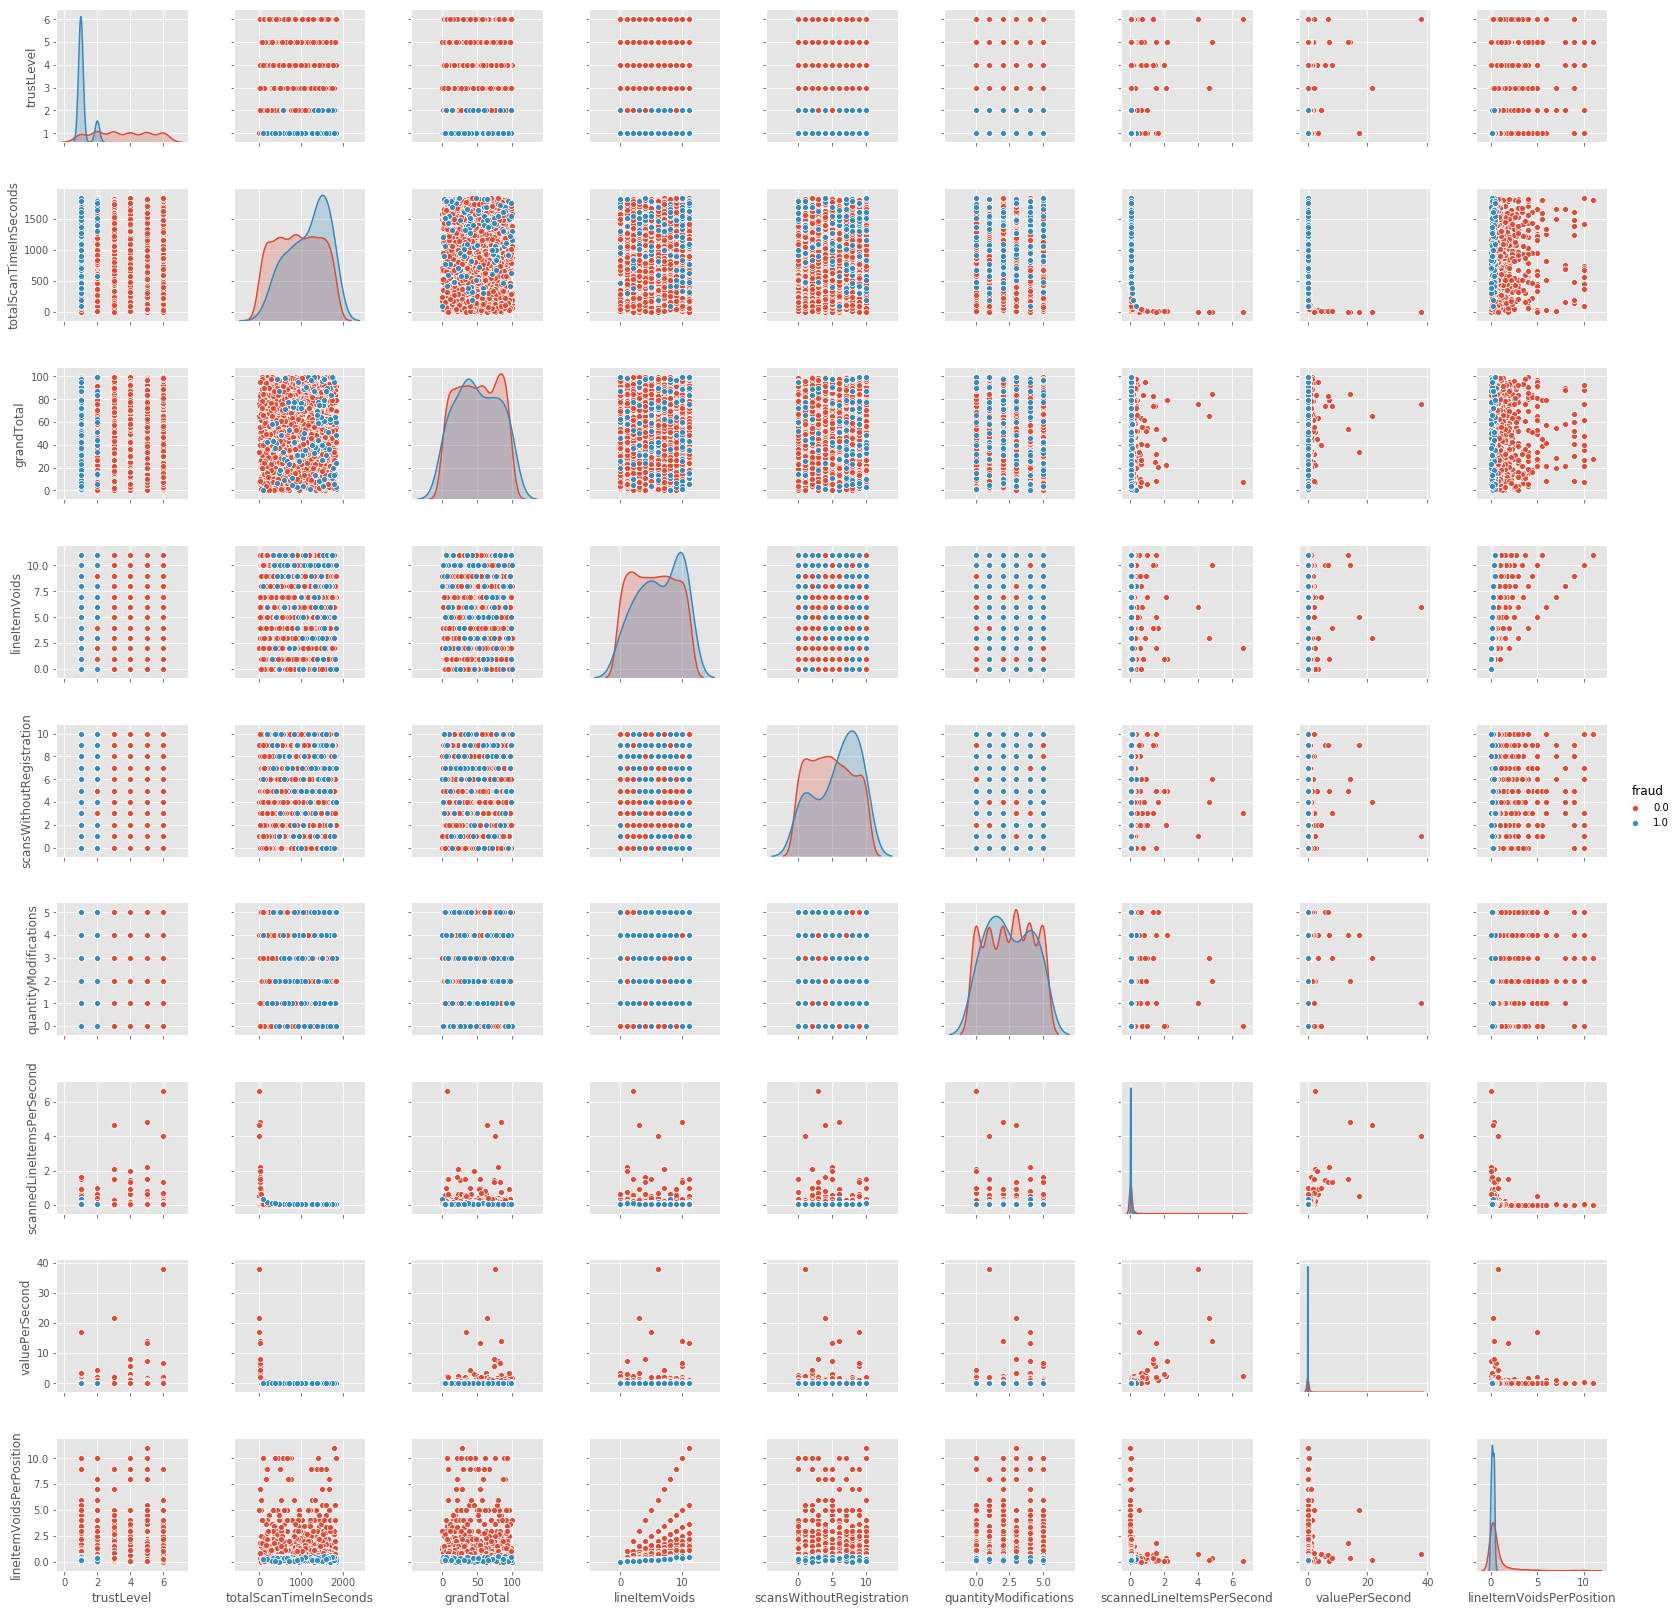

In [45]:
sns.pairplot(DF_Train, hue="fraud", vars=DF_Train.columns[:-1], diag_kind="kde") #kind="reg"

In [ ]:
# read data file, be sure to have working directory at the files location
df = abc2

# mean of Loss will be our KPI to measure performance 

loss = []

for i in range(1,6):
    # generate permutated dataset 
    data = df.sample(frac= 1, random_state=i)
    
    kf = StratifiedKFold(n_splits=5)
    
    # Define X und y 
    
    y = data[['fraud']].values

#    X = data[['trustLevel', 'Positions', 'totalScanTimeInSeconds', 'scansWithoutRegistration', 'lineItemVoids']].values

#    X = data[['trustLevel', 'scansWithoutRegistration', 'Positions', 'totalScanTimeInSeconds', 'lineItemVoids', 'valuePerSecond']].values 
    
#    X = data[['trustLevel', 'scansWithoutRegistration', 'totalScanTimeInSeconds', 'Positions', 'lineItemVoids', 'valuePerSecond']].values [310, 275, 295, 295, 255] Loss:  286.0
    
    X = data[['trustLevel', 'scansWithoutRegistration', 'totalScanTimeInSeconds', 'Positions', 'lineItemVoids', 'lineItemVoidsPerPosition']].values #[375, 305, 285, 265, 290] Loss:  304.0

#    X = data[['trustLevel', 'scansWithoutRegistration', 'totalScanTimeInSeconds', 'Positions', 'lineItemVoids', 'scannedLineItemsPerSecond']].values [315, 275, 295, 285, 265] Loss:  287.0
        
    # prediction will contain the predictions for all our training set 
    prediction = ()  
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
                          
    # Here enter your model (exmple LogisticRegression, Gradient Boost)
                          
        model = SVC()#kernel='linear')
        #model = xgb.XGBClassifier(objective='binary:logistic', seed=123)
        
        model.fit(X_train, y_train)
        prediction = np.append(prediction,model.predict(X_test))
        print(prediction)
        
    
    # create confusion matrix for the predictet values 
    tn, fp, fn, tp = confusion_matrix(y, prediction).ravel()
    print(confusion_matrix(y, prediction))
    loss.append(tn*0 + fn*(-5)+ fp*(-25)+ tp*5)
    
print("Loss: ",loss)
print("Loss: ",np.mean(loss))

In [57]:
# read data file, be sure to have working directory at the files location
df = abc2

# mean of Loss will be our KPI to measure performance 

loss = []

for i in range(1,6):
    # generate permutated dataset 
    data = df.sample(frac= 1, random_state=i)
    
    kf = KFold(n_splits=5)
    
    # Define X und y 
    
    y = data[['fraud']].values

#    X = data[['trustLevel', 'Positions', 'totalScanTimeInSeconds', 'scansWithoutRegistration', 'lineItemVoids']].values

#    X = data[['trustLevel', 'scansWithoutRegistration', 'Positions', 'totalScanTimeInSeconds', 'lineItemVoids', 'valuePerSecond']].values 
    
#    X = data[['trustLevel', 'scansWithoutRegistration', 'totalScanTimeInSeconds', 'Positions', 'lineItemVoids', 'valuePerSecond']].values [310, 275, 295, 295, 255] Loss:  286.0
    
    X = data[['trustLevel', 'scansWithoutRegistration', 'totalScanTimeInSeconds', 'Positions', 'lineItemVoids', 'lineItemVoidsPerPosition']].values #[375, 305, 285, 265, 290] Loss:  304.0

#    X = data[['trustLevel', 'scansWithoutRegistration', 'totalScanTimeInSeconds', 'Positions', 'lineItemVoids', 'scannedLineItemsPerSecond']].values [315, 275, 295, 285, 265] Loss:  287.0
        
    # prediction will contain the predictions for all our training set 
    prediction = ()  
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
                          
    # Here enter your model (exmple LogisticRegression, Gradient Boost)
                          
        model = SVC(kernel='linear')
        #model = xgb.XGBClassifier(objective='binary:logistic', seed=123)
        
        model.fit(X_train, y_train)
        prediction = np.append(prediction,model.predict(X_test))
        
    
    # create confusion matrix for the predictet values 
    tn, fp, fn, tp = confusion_matrix(y, prediction).ravel()
    print(confusion_matrix(y, prediction))
    loss.append(tn*0 + fn*(-5)+ fp*(-25)+ tp*5)
    
print("Loss: ",loss)
print("Loss: ",np.mean(loss))

[[1772    3]
 [   7   97]]
[[1770    5]
 [   9   95]]
[[1768    7]
 [   6   98]]
[[1768    7]
 [   8   96]]
[[1769    6]
 [   8   96]]
Loss:  [375, 305, 285, 265, 290]
Loss:  304.0


## 4. Multicolinearity (inter Correlation)

* When two or more variables are highly correlated with each other.
* Dropping one or more variables should help reduce dimensionality without a substantial loss of information.

There are several ways to avoid this multicollinearty. For example in Ecology it is very common to calculate a correlation matrix between all the independent variables and remove one of them, when the correlation is bigger than "0.7". Another way to investigate the multicollinearty is to calculate the <b>"Variance Inflation Factor"</b> (VIF) for each variable. VIF calculations are straightforward and easily comprehensible: the higher the value, the higher the collinearity. A VIF is calculated for each explanatory variable and those with high values are removed. The definition of "high" is somewhat arbitrary but values in the range of 5-10 are commonly used.

In [23]:
# Calculate the VIF for all the (independent) variables
pd.DataFrame({"VARIABLES": pd.Series(np.linalg.inv(corr_matrix.values).diagonal(), index=corr_matrix.index).keys(),
              "VIF": pd.Series(np.linalg.inv(corr_matrix.values).diagonal(), index=corr_matrix.index).values})

,VARIABLES,VIF
0,trustLevel,1.126546
1,totalScanTimeInSeconds,1.095256
2,grandTotal,1.018233
3,lineItemVoids,1.150700
4,scansWithoutRegistration,1.010284
5,quantityModifications,1.002204
6,scannedLineItemsPerSecond,2.017831
7,valuePerSecond,1.964314
8,lineItemVoidsPerPosition,1.167352
9,fraud,1.161412


## 5. Principal Component Analysis (PCA)

* Dimensionality reduction technique which emphasizes variation.
* Eliminates multicollinearity - but explicability is compromised.
    * Uses orthogonal transformation
* When to use:
    * Excessive multicollinearity
    * Explanation of the predictors is not important.
    * A slight overhead in implementation is okay.

In [24]:
# Standardize the input data
train_scaled = preprocessing.scale(X)
# Perform PCA
pca = PCA().fit(train_scaled)

pca.explained_variance_ratio_

array([0.20356568, 0.14979464, 0.11749997, 0.11463523, 0.10962623,
       0.10437081, 0.09547375, 0.07234693, 0.03268675])

## 6. Cluster analysis

* Dimensionality reduction technique which emphasizes Dimensionality reduction technique which emphasizes correlation/similarity.
* Identify groups of variables that are as correlated possible among themselves Identify groups of variables that are as correlated possible among themselves and as uncorrelated possible with variables in other clusters..
* Reduces multicollinearity Reduces multicollinearity – and explicability is not (always) compromised.
* When to use:
    * Excessive multicollinearity.
    * Explanation of the predictors is important.

In [25]:
X = DF_Test.values
X = preprocessing.scale(X)

k=2
clf = KMeans(n_clusters=k)
clf.fit(X)

centroids = clf.cluster_centers_
labels = clf.labels_

test_set_x = preprocessing.scale(DF_Train.drop('fraud', axis=1).values)
test_set_y = DF_Train.values[:, -1]

prediction = clf.predict(test_set_x).astype(float)

tp = 0
tn = 0
fp = 0
fn = 0
correct = 0
zipped = list(zip(prediction, test_set_y))
for i in range(len(zipped)):
    if zipped[i][0] != zipped[i][1]:
        if np.logical_and(zipped[i][0] == 1, zipped[i][1] == 0):
            fp += 1
        elif np.logical_and(zipped[i][0] == 0, zipped[i][1] == 1):
            fn += 1
            
    if zipped[i][0] == zipped[i][1]:
        if np.logical_and(zipped[i][0] == 1, zipped[i][1] == 1):
            tp += 1
        elif np.logical_and(zipped[i][0] == 0, zipped[i][1] == 0):
            tn += 1
        correct += 1
        
print(correct/len(zipped))
print(f"tn: {tn}, tp: {tp}, fp: {fp}, fn: {fn}")

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_set_y, prediction).ravel()
print(f"tn: {tn}, tp: {tp}, fp: {fp}, fn: {fn}")

0.94252261841405
tn: 1771, tp: 0, fp: 4, fn: 104
tn: 1771, tp: 0, fp: 4, fn: 104


In [26]:
positions = DF_Train.totalScanTimeInSeconds * DF_Train.scannedLineItemsPerSecond
abc = DF_Train.copy()
abc['Positions'] = positions
trustLevels_Dummies = pd.get_dummies(abc.trustLevel.astype(int), prefix='trustLevel')
abc1 = pd.concat([trustLevels_Dummies, abc], axis=1).drop('trustLevel', axis=1)
abc1.head()

,trustLevel_1,trustLevel_2,trustLevel_3,trustLevel_4,trustLevel_5,trustLevel_6,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,Positions
995,0,1,0,0,0,0,216.0,21.97,1.0,5.0,4.0,0.027778,0.101713,0.166667,0.0,6.0
124,0,0,1,0,0,0,770.0,58.93,8.0,0.0,1.0,0.029870,0.076532,0.347826,0.0,23.0
217,0,1,0,0,0,0,1530.0,8.91,4.0,3.0,3.0,0.013072,0.005824,0.200000,0.0,20.0
1425,0,1,0,0,0,0,209.0,82.32,8.0,10.0,4.0,0.076555,0.393876,0.500000,0.0,16.0
1224,0,0,0,0,1,0,550.0,76.36,11.0,1.0,3.0,0.036364,0.138836,0.550000,0.0,20.0


In [27]:
abc2 = abc.copy()
abc2.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,Positions
995,2.0,216.0,21.97,1.0,5.0,4.0,0.027778,0.101713,0.166667,0.0,6.0
124,3.0,770.0,58.93,8.0,0.0,1.0,0.029870,0.076532,0.347826,0.0,23.0
217,2.0,1530.0,8.91,4.0,3.0,3.0,0.013072,0.005824,0.200000,0.0,20.0
1425,2.0,209.0,82.32,8.0,10.0,4.0,0.076555,0.393876,0.500000,0.0,16.0
1224,5.0,550.0,76.36,11.0,1.0,3.0,0.036364,0.138836,0.550000,0.0,20.0


In [30]:
X_T = abc1.drop('fraud', axis=1)

In [31]:
# fit the model
clf = OneClassSVM() # nu=0.1, kernel="rbf", gamma=0.1
clf.fit(X_T)
# y_pred_train = clf.predict(X_train)
# y_pred_test = clf.predict(X_test)
# y_pred_outliers = clf.predict(X_outliers)
# n_error_train = y_pred_train[y_pred_train == -1].size
# n_error_test = y_pred_test[y_pred_test == -1].size
# n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
            kernel='rbf', max_iter=-1, nu=0.5, random_state=None,
            shrinking=True, tol=0.001, verbose=False)

In [34]:
y_pred_train = clf.predict(X_T)
len(y_pred_train)

1879

In [ ]:
# read data file, be sure to have working directory at the files location
df = abc2

# mean of Loss will be our KPI to measure performance 

loss = []

for i in range(1,6):
    # generate permutated dataset 
    data = df.sample(frac= 1, random_state=i)
    #data.to_csv("asdf_"+str(i)+".csv")
    
    kf = StratifiedKFold(n_splits=5)
    
    # Define X und y 
    
    y = data[['fraud']].values
    X = data[['trustLevel', 'Positions', 'totalScanTimeInSeconds', 
             'scansWithoutRegistration', 'lineItemVoids']].values
    
    # prediction will contain the predictions for all our training set 
    prediction = ()  
    
    for train_index, test_index in kf.split(X, y):
    # print("Training set: %s\t Test set: %s" % (train, test))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
                          
    # Here enter your model (exmple LogisticRegression, Gradient Boost)
                          
        model = SVC(kernel='linear')
        #model = xgb.XGBClassifier(objective='binary:logistic', seed=123)
        
        model.fit(X_train, y_train)
        prediction = np.append(prediction,model.predict(X_test))
    
    # create confusion matrix for the predictet values 
    tn, fp, fn, tp = confusion_matrix(y, prediction).ravel()
    
    loss.append(tn*0 + fn*(-5)+ fp*(-25)+ tp*5)
    
print("Loss: ",loss)
print("Loss: ",np.mean(loss))
print("Best Model: 520 (perfect classification)")
print("0-Model: -520")
print("Worst Model: -60k (perfect missclassification)")

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

df = abc2
loss_ = []
loss = []

for i in range(1,6):
    kf = StratifiedKFold(n_splits=5, random_state=i)
    # Define X und y
    y = data[['fraud']].values
    X = data[['trustLevel', 'Positions', 'totalScanTimeInSeconds', 
             'scansWithoutRegistration', 'lineItemVoids']].values
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
                          
        model = SVC(kernel='linear')
        model.fit(X_train, y_train)
        
        tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
        loss_.append(tn*0 + fn*(-5)+ fp*(-25)+ tp*5)
        #print(confusion_matrix(y_test, model.predict(X_test)))
        
    loss.append(loss_)
    loss_ = []
    
loss_check = []
for i in range(len(loss)):
    loss_check.append(np.mean(loss[i]))

print(loss_check)

In [ ]:
X = DF_Train.drop('fraud', axis=1).values
y = DF_Train.values[:, -1]

X = preprocessing.scale(X)

k=2
clf = KMeans(n_clusters=k)
clf.fit(X)

prediction = clf.labels_

tp = 0
tn = 0
fp = 0
fn = 0
correct = 0
zipped = list(zip(prediction, y))
for i in range(len(zipped)):
    if zipped[i][0] != zipped[i][1]:
        if np.logical_and(zipped[i][0] == 1, zipped[i][1] == 0):
            fp += 1
        elif np.logical_and(zipped[i][0] == 0, zipped[i][1] == 1):
            fn += 1
            
    if zipped[i][0] == zipped[i][1]:
        if np.logical_and(zipped[i][0] == 1, zipped[i][1] == 1):
            tp += 1
        elif np.logical_and(zipped[i][0] == 0, zipped[i][1] == 0):
            tn += 1
        correct += 1
        
print(correct/len(zipped))
print(f"tn: {tn}, tp: {tp}, fp: {fp}, fn: {fn}")

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y, prediction).ravel()
print(f"tn: {tn}, tp: {tp}, fp: {fp}, fn: {fn}")

In [ ]:
from sklearn.cluster import MeanShift
from sklearn.datasets.samples_generator import make_blobs
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
style.use("ggplot")

centers = [[1,1,1],[5,5,5],[3,10,10]]

X, _ = make_blobs(n_samples = 100, centers = centers, cluster_std = 1.5)

ms = MeanShift()
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

colors = 10*['r','g','b','c','k','y','m']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]], marker='o')

ax.scatter(cluster_centers[:,0],cluster_centers[:,1],cluster_centers[:,2],
            marker="x",color='k', s=150, linewidths = 5, zorder=10)

plt.show()

In [ ]:
from sklearn.cluster import MeanShift

X = DF_Train.drop('fraud', axis=1).values
# X = preprocessing.scale(X) 
y = DF_Train.values[:, -1]

clf = MeanShift()
clf.fit(X)

prediction = clf.labels_
np.unique(prediction)

In [ ]:
original_df = pd.DataFrame.copy(DF_Train)
X = DF_Train.drop(['fraud'], 1).values.astype(float)
# X = preprocessing.scale(X)
y = np.array(DF_Train['fraud'])

clf = MeanShift()
clf.fit(X)

labels = clf.labels_
cluster_centers = clf.cluster_centers_

original_df['cluster_group'] = labels

n_clusters_ = np.unique(labels)
fraud_rates = {}
for i in range(len(n_clusters_)):
    temp_df = original_df[ (original_df['cluster_group']== i) ]
    fraud_cluster = temp_df[  (temp_df['fraud'] == 1) ]
    fraud_rate = len(fraud_cluster) / len(temp_df)
    #print(len(temp_df))
    #print(len(fraud_cluster))
    fraud_rates[i] = fraud_rate
    
print(fraud_rates)

### 7. Correlation (with the target)

### 8. Forward selection
### 9. Backward elimination
### 10. Stepwise selection

In [84]:
my_model = GradientBoostingClassifier(random_state=random_state).fit(train_X, train_y)
perm = PermutationImportance(my_model, random_state=1).fit(test_X, test_y)
eli5.show_weights(perm, feature_names = DF_Train.iloc[:, 0:9].columns.tolist())

Weight,Feature
0.0668 ± 0.0103,trustLevel
0.0460 ± 0.0116,scannedLineItemsPerSecond
0.0353 ± 0.0099,totalScanTimeInSeconds
0.0217 ± 0.0091,lineItemVoids
0.0191 ± 0.0047,lineItemVoidsPerPosition
0.0051 ± 0.0064,valuePerSecond
0.0051 ± 0.0083,scansWithoutRegistration
0.0013 ± 0.0034,grandTotal
0 ± 0.0000,quantityModifications


In [85]:
train_X, test_X, train_y, test_y = train_test_split(DF_Train.iloc[:, 0:9], DF_Train.iloc[:, 9], random_state=random_state, test_size=0.25)
my_model = RandomForestClassifier(random_state=random_state).fit(train_X, train_y)
perm = PermutationImportance(my_model, random_state=1).fit(test_X, test_y)
eli5.show_weights(perm, feature_names = DF_Train.iloc[:, 0:9].columns.tolist())

Weight,Feature
0.0515 ± 0.0109,trustLevel
0.0268 ± 0.0116,scannedLineItemsPerSecond
0.0234 ± 0.0081,lineItemVoidsPerPosition
0.0174 ± 0.0136,totalScanTimeInSeconds
0.0115 ± 0.0034,lineItemVoids
0.0085 ± 0.0081,valuePerSecond
0.0009 ± 0.0021,quantityModifications
-0.0009 ± 0.0021,grandTotal
-0.0021 ± 0.0071,scansWithoutRegistration


In [86]:
my_model = LogisticRegression(random_state=random_state).fit(train_X, train_y)
perm = PermutationImportance(my_model, random_state=1).fit(test_X, test_y)
eli5.show_weights(perm, feature_names = DF_Train.iloc[:, 0:9].columns.tolist())

Weight,Feature
0.0481 ± 0.0136,trustLevel
0.0379 ± 0.0141,lineItemVoidsPerPosition
0.0353 ± 0.0088,lineItemVoids
0.0157 ± 0.0106,totalScanTimeInSeconds
0.0102 ± 0.0102,scansWithoutRegistration
0.0017 ± 0.0032,quantityModifications
0.0017 ± 0.0017,grandTotal
0.0009 ± 0.0021,valuePerSecond
0.0009 ± 0.0021,scannedLineItemsPerSecond


In [87]:
my_model = MLPClassifier(random_state=random_state).fit(train_X, train_y)
perm = PermutationImportance(my_model, random_state=1).fit(test_X, test_y)
eli5.show_weights(perm, feature_names = DF_Train.iloc[:, 0:9].columns.tolist())

Weight,Feature
0.0013 ± 0.0021,trustLevel
0.0004 ± 0.0017,grandTotal
0 ± 0.0000,lineItemVoidsPerPosition
0 ± 0.0000,valuePerSecond
0 ± 0.0000,scannedLineItemsPerSecond
0 ± 0.0000,quantityModifications
0 ± 0.0000,scansWithoutRegistration
0 ± 0.0000,lineItemVoids
0 ± 0.0000,totalScanTimeInSeconds


###  Feature Engineering

In [88]:
DF = DF_Train.drop(['fraud'], axis = 1).astype(float)

# New Features
positions = DF.totalScanTimeInSeconds * DF.scannedLineItemsPerSecond
lineItemVoidsPerSecond = DF.lineItemVoids / DF.totalScanTimeInSeconds
grandTotalPerPosition = DF.grandTotal / positions
scansWithoutRegistraionPerPosition = DF.scansWithoutRegistration / positions
quantityModificationsPerPosition = DF.quantityModifications / positions

# Relation between the features
print((DF.lineItemVoids == np.round(DF.totalScanTimeInSeconds * DF.scannedLineItemsPerSecond * DF.lineItemVoidsPerPosition)).all())

True


### Evaluation
The models will be assessed and compared based on their monetary value for the food retailer. This can be calculated using the following cost matrix based on empirical observation.


In [89]:
class custom_loss:
    def cost(true_label, predicted_label):
        tn, fp, fn, tp = confusion_matrix(true_label, predicted_label).ravel()
        loss = (tn*0) + (fn*(-5)) + (fp*(-25)) + (tp*5)
        return(loss)
    
    def cm(true_label, predicted_label):
        con_ma = confusion_matrix(true_label, predicted_label)
        return(con_ma)

In [95]:
model = LogisticRegression(random_state=random_state)
score = make_scorer(custom_loss.cost, greater_is_better=True)

#For integer/None inputs, if the estimator is a classifier and ``y`` is
#either binary or multiclass, :class:`StratifiedKFold` is used. In all
#other cases, :class:`KFold` is used.

param_grid = {'C': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 
                    1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]}

grid = GridSearchCV(model,
                    scoring=score,
                    cv=5, param_grid=param_grid)
grid.fit(X,y)

print(grid.best_estimator_)
#print(grid.grid_scores_)
#print(grid.cv_results_)

LogisticRegression(C=10000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [91]:
from sklearn.model_selection import KFold, StratifiedKFold

loss_ = []
loss = []
regularization = np.array([1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 
                          1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10])

for i in range(len(regularization)):
    kf = StratifiedKFold(n_splits=5)
    # Define X und y
    X = X
    y = y
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
                          
        model = LogisticRegression(random_state = 0, C=regularization[i])
        model.fit(X_train, y_train)
        
        tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
        loss_.append(tn*0 + fn*(-5)+ fp*(-25)+ tp*5)
        #print(confusion_matrix(y_test, model.predict(X_test)))
        
    loss.append(loss_)
    loss_ = []
    
loss_check = []
for i in range(len(loss)):
    loss_check.append(np.mean(loss[i]))

#print(loss_check)

In [92]:
def GridSCV(X, y, classifier, par_grid, cv=5):
    model = classifier
    score = make_scorer(custom_loss.cost, greater_is_better=True)
    param_grid = par_grid
    grid = GridSearchCV(model, scoring=score, cv=cv, param_grid=param_grid, error_score=np.nan)
    grid.fit(X,y)
    return(grid)

In [93]:
classifiers = [LogisticRegression(random_state=random_state), SGDClassifier(random_state=random_state),
               SVC(random_state=random_state), LinearSVC(random_state=random_state), NuSVC(random_state=random_state),
               MultinomialNB(), BernoulliNB(), GaussianNB(),
               RandomForestClassifier(random_state=random_state), GradientBoostingClassifier(random_state=random_state),
               MLPClassifier(random_state=random_state)]

clf_names = ['LogisticRegression', 'SGDClassifier',
             'SVC', 'LinearSVC', 'NuSVC',
             'MultinomialNB', 'BernoulliNB', 'GaussianNB',
             'RandomForest', 'GradientBoosting', 'MLP']

# define the parameter values that should be searched
penalty_options = ['l1', 'l2']
C_options = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
fit_intercept_options = [False, True]
tol_options = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+1, 1e+2]
solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# creating a parameter grid: map the parameter names to the values that should be searched
param_grid = [dict(penalty=penalty_options, C=C_options, fit_intercept=fit_intercept_options, tol=tol_options, solver=solver_options)]

# instantiate and fit the grid using GridSCV function
Grid = GridSCV(X=X, y=y, classifier=classifiers[0], par_grid=param_grid[0])

In [94]:
Grid.best_estimator_

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=1e-05, verbose=0, warm_start=False)

In [273]:
# read data file, be sure to have working directory at the files location
df = abc1

# mean of Loss will be our KPI to measure performance 

loss = []

for i in range(1,6):
    # generate permutated dataset 
    data = df.sample(frac= 1, random_state=i)
    #data.to_csv("asdf_"+str(i)+".csv")
    
    kf = KFold(n_splits=5)
    
    # Define X und y 
    
    y = data[['fraud']].values
    X = data[['trustLevel_1', 'trustLevel_2', 'trustLevel_3', 'trustLevel_4', 'trustLevel_5', 'trustLevel_6', 'Positions', 'totalScanTimeInSeconds', 
             'scansWithoutRegistration', 'lineItemVoids']].values
    
    # prediction will contain the predictions for all our training set 
    prediction = ()  
    
    for train_index, test_index in kf.split(X):
    # print("Training set: %s\t Test set: %s" % (train, test))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
                          
    # Here enter your model (exmple LogisticRegression, Gradient Boost)
                          
        model = SVC(kernel='linear')
        #model = xgb.XGBClassifier(objective='binary:logistic', seed=123)
        
        model.fit(X_train, y_train)
        prediction = np.append(prediction,model.predict(X_test))
    
    # create confusion matrix for the predictet values 
    tn, fp, fn, tp = confusion_matrix(y, prediction).ravel()
    
    loss.append(tn*0 + fn*(-5)+ fp*(-25)+ tp*5)
    
print("Loss: ",loss)
print("Loss: ",np.mean(loss))
print("Best Model: 520 (perfect classification)")
print("0-Model: -520")
print("Worst Model: -60k(perfect missclassification)")

Loss:  [-2600, -2600, -2600, -2600, -2600]
Loss:  -2600.0
Best Model: 520 (perfect classification)
0-Model: -520
Worst Model: -60k(perfect missclassification)


### Future works

- plotting the gridserchCV scores
- define treshhold for probability of classifiers for semi-supervised learning
- feature selection slides
- combination of dataFrames
- change the trustlevel column to binary columns
- how to use clustering in feature selection
- how to handle the unblanced data set
- OneCLassSVM Scikitlearn
- anamoly detection
- unsupervised learning Methods